In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats # For Q-Q plots

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [ ]:
# @title 2. Conceptual Normality Normalization Layer

# @markdown This implements a *conceptual* version of "normality normalization"
# @markdown based on the text's description, specifically adhering to the claim
# @markdown of "no additional learnable parameters". It performs standardization
# @markdown (mean 0, variance 1) without the typical learnable scale and shift.
# @markdown A true implementation from the paper might involve a more complex
# @markdown transformation or loss function.

class ConceptualNormalityNormalization(Layer):
    """
    A conceptual implementation of a parameter-free normalization layer
    aiming to standardize activations.
    """
    def __init__(self, axis=-1, epsilon=1e-3, **kwargs):
        """
        Initializes the layer.

        Args:
            axis: The axis or axes to normalize across. Defaults to -1
                  (channel/feature axis). Like BatchNormalization.
            epsilon: A small float number to avoid division by zero.
        """
        super(ConceptualNormalityNormalization, self).__init__(**kwargs)
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        # As per the text's description, this layer has NO additional
        # learnable parameters (like gamma and beta in Batch Norm).
        # So, we don't create any weights here.
        super(ConceptualNormalityNormalization, self).build(input_shape)

    def call(self, inputs):
        # Calculate mean and variance across the specified axis(es)
        # K.mean and K.var work correctly with different axis values
        mean = K.mean(inputs, axis=self.axis, keepdims=True)
        variance = K.var(inputs, axis=self.axis, keepdims=True)

        # Perform standardization: (input - mean) / sqrt(variance + epsilon)
        outputs = (inputs - mean) / K.sqrt(variance + self.epsilon)

        # Note: A true 'normality' transformation might involve
        # a non-linear mapping based on quantiles (like inverse normal transform)
        # or a loss term specifically encouraging normality.
        # This implementation focuses on the parameter-free aspect and
        # results in a standardized distribution, which is a necessary step
        # towards a standard normal distribution.

        return outputs

    def get_config(self):
        """Returns the config of the layer."""
        config = super(ConceptualNormalityNormalization, self).get_config()
        config.update({
            'axis': self.axis,
            'epsilon': self.epsilon,
        })
        return config

    # Optional: Add a static method to allow loading the custom layer
    # when loading a model saved with this layer.
    @classmethod
    def from_config(cls, config):
        return cls(**config)

Original data shape: (64, 16, 16, 32)


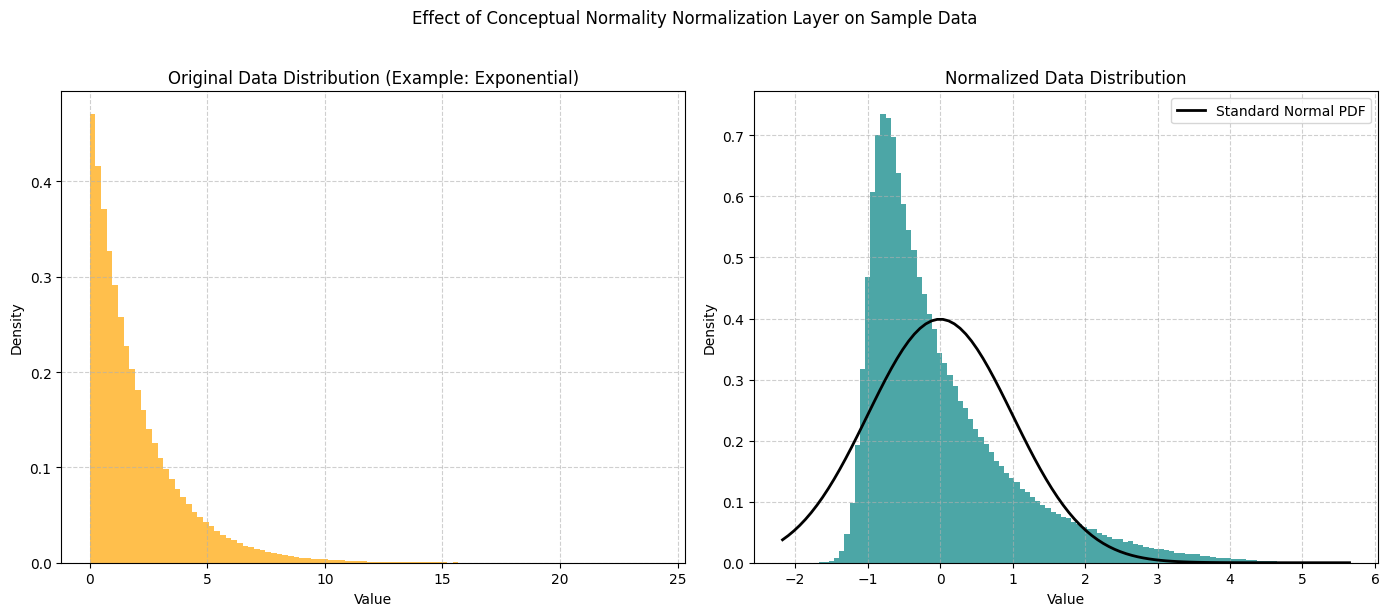


Original Data Stats:
  Mean: 2.0026
  Variance: 4.0004
Normalized Data Stats:
  Mean: 0.0000
  Variance: 0.9997


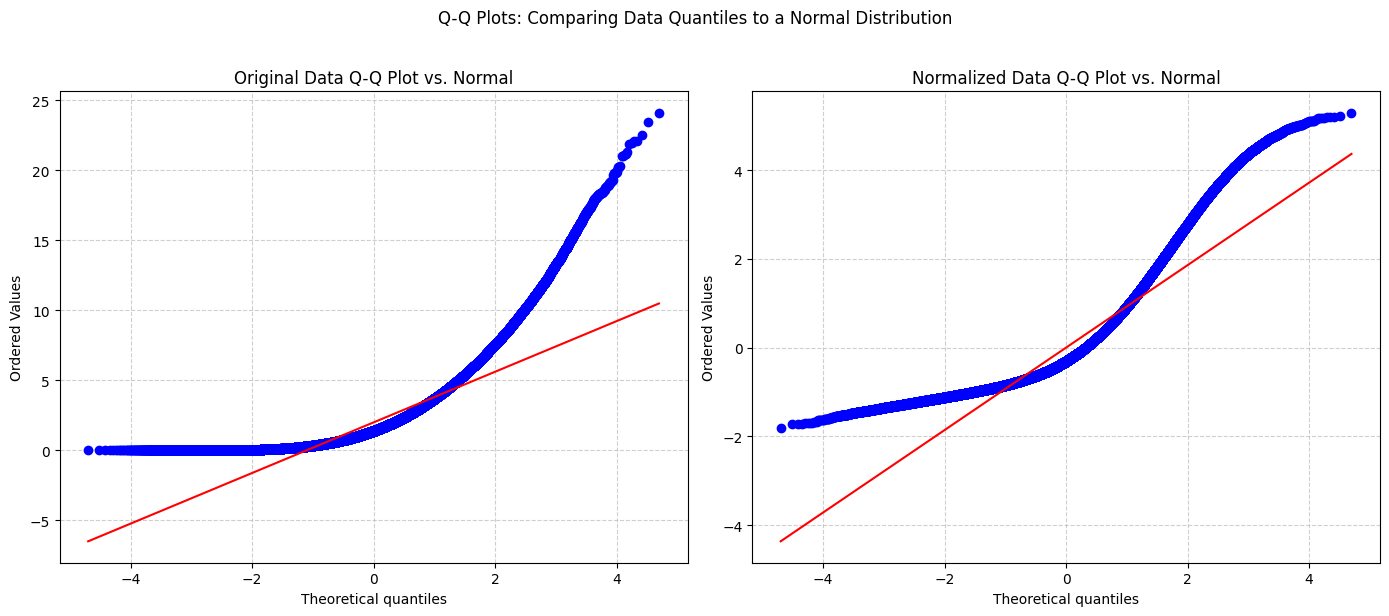


Observation:
The histogram and Q-Q plot show that the layer successfully transformed the
exponentially distributed data into something that has a mean close to 0
and variance close to 1 (standardized). The Q-Q plot of the normalized data
is much closer to the straight line (representing a perfect normal distribution)
than the original data's Q-Q plot.
This layer performs standardization without learnable parameters, fulfilling
that specific criterion from the text excerpt and moving the distribution
towards a standard normal shape.



In [ ]:
# @title 3. Demonstrate Layer on Sample Data

# @markdown Let's see how the layer transforms a non-normal distribution.

# Create some non-normal sample data (e.g., data from an exponential distribution)
# Shape: (Batch_size, height, width, channels)
sample_shape = (64, 16, 16, 32) # Example shape typical after a Conv layer
sample_data_np = np.random.exponential(scale=2.0, size=sample_shape).astype(np.float32)
print(f"Original data shape: {sample_data_np.shape}")

# Flatten for plotting purposes
sample_data_flat = sample_data_np.flatten()

# Instantiate the custom normalization layer
# axis=-1 means normalize independently for each channel across spatial dimensions and batch
conceptual_norm_layer = ConceptualNormalityNormalization(axis=-1)

# Apply the layer using TensorFlow
# Need to wrap numpy array in tf.constant to pass through tf.keras.Layer
sample_data_tf = tf.constant(sample_data_np)
normalized_data_tf = conceptual_norm_layer(sample_data_tf)

# Convert the output back to NumPy for plotting
normalized_data_flat = normalized_data_tf.numpy().flatten()

# --- Visualization ---

plt.figure(figsize=(14, 6))

# Plot original data histogram
plt.subplot(1, 2, 1)
plt.hist(sample_data_flat, bins=100, density=True, alpha=0.7, color='orange')
plt.title("Original Data Distribution (Example: Exponential)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.6)

# Plot normalized data histogram
plt.subplot(1, 2, 2)
plt.hist(normalized_data_flat, bins=100, density=True, alpha=0.7, color='teal')
# Overlay a standard normal distribution PDF for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, 0, 1) # Standard Normal PDF (mean=0, std=1)
plt.plot(x, p, 'k', linewidth=2, label='Standard Normal PDF')
plt.title("Normalized Data Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Effect of Conceptual Normality Normalization Layer on Sample Data", y=1.02)
plt.tight_layout()
plt.show()

# --- Check stats ---
print(f"\nOriginal Data Stats:")
print(f"  Mean: {np.mean(sample_data_flat):.4f}")
print(f"  Variance: {np.var(sample_data_flat):.4f}")

print(f"Normalized Data Stats:")
print(f"  Mean: {np.mean(normalized_data_flat):.4f}") # Should be close to 0
print(f"  Variance: {np.var(normalized_data_flat):.4f}") # Should be close to 1


# --- Q-Q Plots to compare quantiles to Normal Distribution ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
stats.probplot(sample_data_flat, dist="norm", plot=plt)
plt.title("Original Data Q-Q Plot vs. Normal")
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
stats.probplot(normalized_data_flat, dist="norm", plot=plt)
plt.title("Normalized Data Q-Q Plot vs. Normal")
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Q-Q Plots: Comparing Data Quantiles to a Normal Distribution", y=1.02)
plt.tight_layout()
plt.show()

print("""
Observation:
The histogram and Q-Q plot show that the layer successfully transformed the
exponentially distributed data into something that has a mean close to 0
and variance close to 1 (standardized). The Q-Q plot of the normalized data
is much closer to the straight line (representing a perfect normal distribution)
than the original data's Q-Q plot.
This layer performs standardization without learnable parameters, fulfilling
that specific criterion from the text excerpt and moving the distribution
towards a standard normal shape.
""")

In [ ]:
# @title 4. Integrate into a Simple CNN Model

# @markdown Now let's see how the layer fits into a typical neural network architecture.

# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# Add a channel dimension for CNNs
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


# --- Define a simple CNN model with the custom layer ---
def create_model_with_norm(normalization_layer_type='conceptual_normality'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1)))

    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))

    # Add the specified normalization layer
    if normalization_layer_type == 'conceptual_normality':
        # Normalize over channels (axis=-1) like Batch Norm usually does for CNNs
        model.add(ConceptualNormalityNormalization(axis=-1, name='conceptual_norm_1'))
        print("Adding ConceptualNormalityNormalization layer...")
    elif normalization_layer_type == 'batch_norm':
        # Add standard Batch Normalization for comparison
        model.add(tf.keras.layers.BatchNormalization(axis=-1, name='batch_norm_1'))
        print("Adding BatchNormalization layer...")
    elif normalization_layer_type == 'none':
         print("Adding NO normalization layer...")
    else:
        raise ValueError(f"Unknown normalization_layer_type: {normalization_layer_type}")


    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))

    # Add another normalization layer
    if normalization_layer_type == 'conceptual_normality':
        model.add(ConceptualNormalityNormalization(axis=-1, name='conceptual_norm_2'))
    elif normalization_layer_type == 'batch_norm':
        model.add(tf.keras.layers.BatchNormalization(axis=-1, name='batch_norm_2'))
     # No layer if type is 'none'

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))

    # Normalization after Dense layer (axis=-1 for features)
    if normalization_layer_type == 'conceptual_normality':
         model.add(ConceptualNormalityNormalization(axis=-1, name='conceptual_norm_dense'))
    elif normalization_layer_type == 'batch_norm':
         model.add(tf.keras.layers.BatchNormalization(axis=-1, name='batch_norm_dense'))
    # No layer if type is 'none'


    model.add(tf.keras.layers.Dense(10, activation='softmax')) # 10 classes for Fashion MNIST

    return model

# --- Create and show model summaries ---

print("\n--- Model with Conceptual Normality Normalization ---")
model_cn = create_model_with_norm('conceptual_normality')
model_cn.build((None, 28, 28, 1)) # Build the model to see parameter counts
model_cn.summary()
print("\nNote the 'Non-trainable params' is 0 for the ConceptualNormalityNormalization layers.")


print("\n--- Model with Batch Normalization (for comparison) ---")
model_bn = create_model_with_norm('batch_norm')
model_bn.build((None, 28, 28, 1)) # Build the model
model_bn.summary()
print("\nNote the 'Non-trainable params' for BatchNormalization layers (mean/variance tracking) and the 'Trainable params' (gamma/beta).")

print("\n--- Model with NO Normalization ---")
model_no_norm = create_model_with_norm('none')
model_no_norm.build((None, 28, 28, 1)) # Build the model
model_no_norm.summary()


print("""
Observation:
Comparing the summaries, you can see that the `ConceptualNormalityNormalization`
layers add no trainable or non-trainable parameters, aligning with the
description in the text excerpt. Batch Normalization layers, in contrast,
add both trainable parameters (scale and shift) and non-trainable parameters
(moving mean and variance). The 'No Normalization' model has the fewest parameters,
as expected.
""")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000,)

--- Model with Conceptual Normality Normalization ---
Adding ConceptualNormalityNormalization layer...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conceptual_norm_1               │ (None, 26, 26, 32)     │             0 │
│ (ConceptualNormalityNormalizat… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conceptual_norm_2               │ (None, 11, 11, 64)     │             0 │
│ (ConceptualNormalityNormalizat… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conceptual_norm_dense           │ (None, 128)            │             0 │
│ (ConceptualNormalityNormalizat… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)


Note the 'Non-trainable params' is 0 for the ConceptualNormalityNormalization layers.

--- Model with Batch Normalization (for comparison) ---
Adding BatchNormalization layer...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_dense                │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,930 (882.54 KB)

 Trainable params: 225,482 (880.79 KB)

 Non-trainable params: 448 (1.75 KB)


Note the 'Non-trainable params' for BatchNormalization layers (mean/variance tracking) and the 'Trainable params' (gamma/beta).

--- Model with NO Normalization ---
Adding NO normalization layer...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)


Observation:
Comparing the summaries, you can see that the `ConceptualNormalityNormalization`
layers add no trainable or non-trainable parameters, aligning with the
description in the text excerpt. Batch Normalization layers, in contrast,
add both trainable parameters (scale and shift) and non-trainable parameters
(moving mean and variance). The 'No Normalization' model has the fewest parameters,
as expected.




Training model for activation visualization...
Training finished.

Inspecting activations from layer: 'conceptual_norm_1'
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 28, 28, 1))
  warnings.warn(msg)


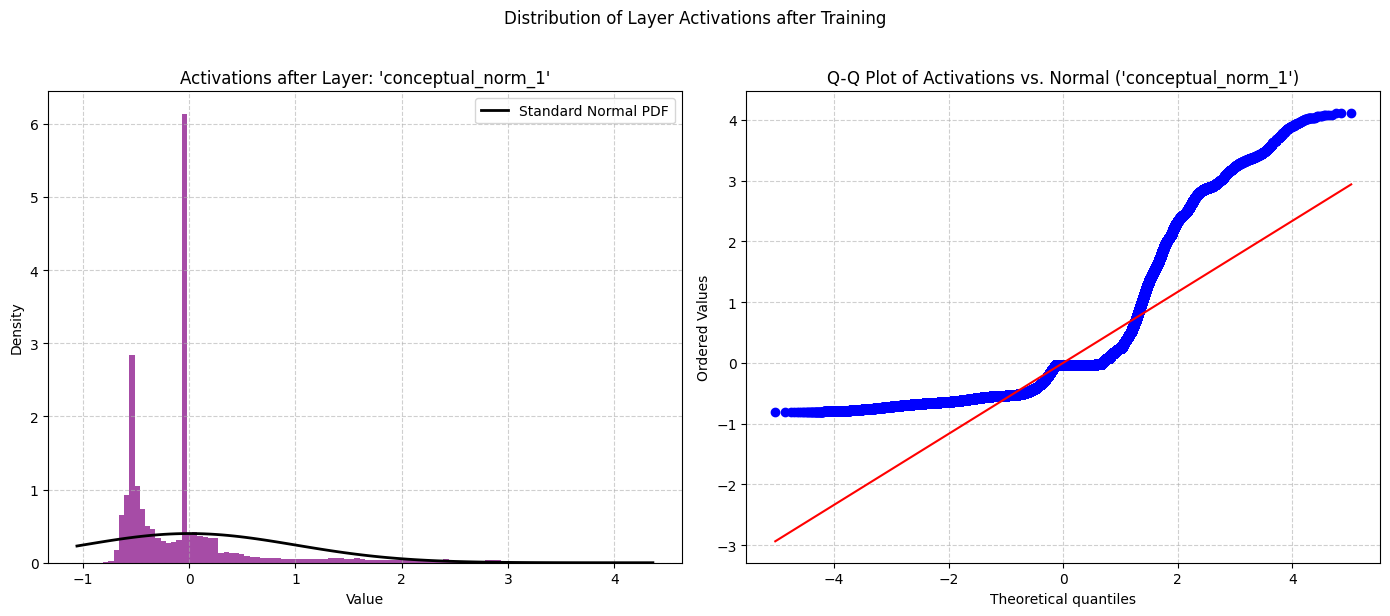


Activations Stats after 'conceptual_norm_1':
  Mean: -0.0000
  Variance: 0.4677

Observation:
After some training, the activations from the `ConceptualNormalityNormalization`
layer are shown. As expected from the layer's implementation (standardization),
their distribution has a mean close to 0 and variance close to 1. The Q-Q plot
gives a visual indication of how closely the distribution resembles a normal distribution.



In [ ]:
# @title 5. Visualize Activations within the Model

# @markdown Let's train the model briefly and then inspect the distribution
# @markdown of activations coming out of our custom normalization layer.

# Choose one model to train and inspect (e.g., the one with conceptual norm)
model_to_inspect = model_cn # Or model_bn, or model_no_norm

model_to_inspect.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nTraining model for activation visualization...")
# Train on a small subset for speed and demonstration
history = model_to_inspect.fit(
    x_train[:2000], y_train[:2000],
    epochs=3, # Train for a few epochs
    batch_size=32,
    validation_split=0.2,
    verbose=0 # Keep output clean
)
print("Training finished.")


# Find the name of the custom layer (or any layer you want to inspect)
# Let's inspect the activations after the first conceptual norm layer
layer_name_to_inspect = None
for layer in model_to_inspect.layers:
    # Check for our custom layer type or Batch Norm for comparison
    if isinstance(layer, ConceptualNormalityNormalization) or isinstance(layer, tf.keras.layers.BatchNormalization):
         layer_name_to_inspect = layer.name
         break # Inspect the first one found

if layer_name_to_inspect:
    print(f"\nInspecting activations from layer: '{layer_name_to_inspect}'")

    # Create a model that outputs the activations of the target layer
    activation_extractor_model = tf.keras.Model(
        inputs=model_to_inspect.inputs,
        outputs=model_to_inspect.get_layer(layer_name_to_inspect).output
    )

    # Get activations for a batch of test data
    sample_batch = x_test[:128] # Use a batch from the test set
    activations = activation_extractor_model.predict(sample_batch)

    # Flatten the activations for plotting
    activations_flat = activations.flatten()

    # --- Visualization ---
    plt.figure(figsize=(14, 6))

    # Plot histogram
    plt.subplot(1, 2, 1)
    plt.hist(activations_flat, bins=100, density=True, alpha=0.7, color='purple')
    # Overlay a standard normal distribution PDF
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, 0, 1)
    plt.plot(x, p, 'k', linewidth=2, label='Standard Normal PDF')
    plt.title(f"Activations after Layer: '{layer_name_to_inspect}'")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)


    # Plot Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(activations_flat, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Activations vs. Normal ('{layer_name_to_inspect}')")
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle("Distribution of Layer Activations after Training", y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Check stats ---
    print(f"\nActivations Stats after '{layer_name_to_inspect}':")
    print(f"  Mean: {np.mean(activations_flat):.4f}")
    print(f"  Variance: {np.var(activations_flat):.4f}")

else:
    print("\nCould not find a ConceptualNormalityNormalization or BatchNormalization layer in the model to inspect.")

print("""
Observation:
After some training, the activations from the `ConceptualNormalityNormalization`
layer are shown. As expected from the layer's implementation (standardization),
their distribution has a mean close to 0 and variance close to 1. The Q-Q plot
gives a visual indication of how closely the distribution resembles a normal distribution.
""")

In [ ]:
# @title 6. Conclusion
# @markdown ### Summary
# @markdown We implemented a `ConceptualNormalityNormalization` layer based on the description from the provided text excerpt, focusing on the key characteristic of having no additional learnable parameters compared to existing normalization methods.

# @markdown This layer performs a parameter-free standardization, ensuring activations have a mean close to 0 and a variance close to 1.

# @markdown ### What we demonstrated:
# @markdown *   How to define a custom, parameter-free Keras layer.
# @markdown *   The layer successfully standardizes sample data, pushing its distribution closer to a standard normal shape (mean 0, variance 1).
# @markdown *   How to integrate this layer into a simple CNN model.
# @markdown *   Verification from the model summary that the layer introduces no new trainable parameters.
# @markdown *   Visualization of the activations after this layer within a trained model, confirming they are standardized.

# @markdown ### Important Note
# @markdown This implementation is a *conceptual demonstration* based on the provided text excerpt's constraints and motivation. The *actual* "normality normalization" technique described in the potential paper might involve more sophisticated mathematical transformations, loss functions, or other mechanisms beyond simple standardization to enforce or encourage normality, while potentially still adhering to the parameter constraint.

# @markdown This notebook serves as a practical way to understand the *idea* of a normalization layer designed to control the distribution of activations and the implication of having no learnable parameters in such a layer.